# Test del Modelo Random Forest en Coronel Suárez

Este notebook testea el modelo Random Forest entrenado con datos de Tres Arroyos en el área de Coronel Suárez.

El modelo fue entrenado con las siguientes clases agrupadas:
- **CULTIVO AGRÍCOLA**: Maíz (10), Soja (11), Girasol (12), Sorgo (18), Papa (26)
- **BARBECHO**: Barbecho (21)
- **NO AGRÍCOLA**: No agrícola (22) y 255 (nodata/máscara)

Se evaluarán las métricas de clasificación y se generarán visualizaciones comparando las predicciones con las categorías reales del INTA.


In [11]:
import numpy as np
import pandas as pd
import rasterio
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import joblib
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# ============================================================================
# CONFIGURACION DE PATHS
# ============================================================================

# Directorio base del proyecto
PROJECT_ROOT = os.path.join("..", "..")
DATA_PROC_DIR = os.path.join(PROJECT_ROOT, "data", "proc")

# Archivo de entrada: raster de Coronel Suárez
RASTER_PATH = os.path.join(DATA_PROC_DIR, "11_NDVI_inta_verano_coronel_suarez.tif")

# Ruta del modelo entrenado
MODELO_PATH = os.path.join(DATA_PROC_DIR, "11_rf_model_50_estimators.pkl")

# Convertir a rutas absolutas para verificación
RASTER_PATH_ABS = os.path.abspath(RASTER_PATH)
MODELO_PATH_ABS = os.path.abspath(MODELO_PATH)

print("=" * 80)
print("CONFIGURACION DE PATHS")
print("=" * 80)
print(f"Raster de entrada (relativo): {RASTER_PATH}")
print(f"Raster de entrada (absoluto): {RASTER_PATH_ABS}")
print(f"Archivo existe: {os.path.exists(RASTER_PATH)}")
print(f"\nModelo (relativo): {MODELO_PATH}")
print(f"Modelo (absoluto): {MODELO_PATH_ABS}")
print(f"Modelo existe: {os.path.exists(MODELO_PATH)}")


CONFIGURACION DE PATHS
Raster de entrada (relativo): ..\..\data\proc\11_NDVI_inta_verano_coronel_suarez.tif
Raster de entrada (absoluto): e:\ade_modelo_agricola\data\proc\11_NDVI_inta_verano_coronel_suarez.tif
Archivo existe: True

Modelo (relativo): ..\..\data\proc\11_rf_model_50_estimators.pkl
Modelo (absoluto): e:\ade_modelo_agricola\data\proc\11_rf_model_50_estimators.pkl
Modelo existe: True


## Cargar modelo y datos


In [12]:
# ============================================================================
# CARGAR MODELO
# ============================================================================

print("=" * 80)
print("CARGANDO MODELO")
print("=" * 80)

if os.path.exists(MODELO_PATH):
    print(f"Cargando modelo desde: {MODELO_PATH}")
    rf_model = joblib.load(MODELO_PATH)
    print("[OK] Modelo cargado exitosamente")
    print(f"  Número de estimadores: {rf_model.n_estimators}")
    print(f"  Número de features: {rf_model.n_features_in_}")
else:
    raise FileNotFoundError(f"Modelo no encontrado en: {MODELO_PATH}")

# ============================================================================
# CARGAR DATOS DEL RASTER
# ============================================================================

print("\n" + "=" * 80)
print("CARGANDO DATOS DEL RASTER")
print("=" * 80)

with rasterio.open(RASTER_PATH) as src:
    # Leer banda 1: categorías INTA verano
    categorias_inta = src.read(1)
    
    # Leer bandas 2-12: features (estadísticas + series temporales)
    # Banda 2-5: estadísticas (mediana, min, max, std)
    # Banda 6-12: series temporales NDVI (7 bandas desde diciembre 2023)
    features_list = []
    for i in range(2, 13):
        banda = src.read(i).astype(np.float32)
        if src.nodata is not None:
            banda[banda == src.nodata] = np.nan
        features_list.append(banda)
    
    # Apilar features: shape (11, height, width)
    X_all = np.stack(features_list, axis=0)
    
    # Obtener metadata
    height, width = categorias_inta.shape
    transform = src.transform
    crs = src.crs
    
    print(f"Dimensiones del raster: {height} x {width}")
    print(f"CRS: {crs}")
    print(f"Número de features: {X_all.shape[0]}")

# Reshape para tener (n_pixels, n_features)
n_pixels = height * width
X_all = X_all.reshape(X_all.shape[0], -1).T  # Shape: (n_pixels, n_features)
categorias_inta_flat = categorias_inta.flatten()

print(f"\nDatos reshapeados:")
print(f"  X_all shape: {X_all.shape}")
print(f"  categorias_inta_flat shape: {categorias_inta_flat.shape}")

# ============================================================================
# CREAR VARIABLE OBJETIVO AGRUPADA
# ============================================================================

print("\n" + "=" * 80)
print("CREANDO VARIABLE OBJETIVO AGRUPADA")
print("=" * 80)

# Definir mapeo de categorías (igual que en el entrenamiento)
cultivos_agricolas = [10, 11, 12, 18, 26]  # Maíz, Soja, Girasol, Sorgo, Papa
barbecho = [21]
no_agricola = [22, 255]

# Convertir categorias_inta_flat a float para manejar NaN
categorias_inta_flat_float = categorias_inta_flat.astype(np.float32)

# Crear variable objetivo agrupada
y_agrupado = np.full_like(categorias_inta_flat_float, -1, dtype=np.float32)

for cat_val in cultivos_agricolas:
    y_agrupado[categorias_inta_flat_float == cat_val] = 0  # CULTIVO AGRÍCOLA

y_agrupado[categorias_inta_flat_float == 21] = 1  # BARBECHO

for cat_val in no_agricola:
    y_agrupado[categorias_inta_flat_float == cat_val] = 2  # NO AGRÍCOLA

# Agrupar NaN junto con "NO AGRÍCOLA"
mask_nan = np.isnan(categorias_inta_flat_float)
y_agrupado[mask_nan] = 2  # NO AGRÍCOLA

# Convertir a int32 para las clases
y_agrupado = y_agrupado.astype(np.int32)

# Filtrar píxeles válidos (ahora todos deberían tener clase asignada)
mask_valido = y_agrupado >= 0
X_valido = X_all[mask_valido]
y_valido = y_agrupado[mask_valido]

# Filtrar píxeles con NaN en features
mask_sin_nan = ~np.any(np.isnan(X_valido), axis=1)
X_clean = X_valido[mask_sin_nan]
y_clean = y_valido[mask_sin_nan]

# Obtener índices de píxeles válidos
indices_validos = np.where(mask_valido)[0]
indices_clean = indices_validos[mask_sin_nan]

# Nombres de clases
nombres_clases = ['CULTIVO AGRÍCOLA', 'BARBECHO', 'NO AGRÍCOLA']

print(f"\nPíxeles válidos: {len(X_clean):,}")
print(f"Distribución de clases:")
clases_unicas, conteos = np.unique(y_clean, return_counts=True)
for clase_idx, conteo in zip(clases_unicas, conteos):
    print(f"  {nombres_clases[clase_idx]}: {conteo:,} píxeles ({100*conteo/len(y_clean):.2f}%)")


CARGANDO MODELO
Cargando modelo desde: ..\..\data\proc\11_rf_model_50_estimators.pkl
[OK] Modelo cargado exitosamente
  Número de estimadores: 50
  Número de features: 11

CARGANDO DATOS DEL RASTER
Dimensiones del raster: 2651 x 2646
CRS: EPSG:32721
Número de features: 11

Datos reshapeados:
  X_all shape: (7014546, 11)
  categorias_inta_flat shape: (7014546,)

CREANDO VARIABLE OBJETIVO AGRUPADA

Píxeles válidos: 7,014,119
Distribución de clases:
  CULTIVO AGRÍCOLA: 2,622,469 píxeles (37.39%)
  BARBECHO: 1,549,264 píxeles (22.09%)
  NO AGRÍCOLA: 2,842,386 píxeles (40.52%)


## Generar predicciones


In [13]:
# ============================================================================
# GENERAR PREDICCIONES
# ============================================================================

print("=" * 80)
print("GENERANDO PREDICCIONES")
print("=" * 80)

tiempo_inicio = time.time()
y_pred = rf_model.predict(X_clean)
tiempo_prediccion = time.time() - tiempo_inicio

print(f"[OK] Predicciones generadas en {tiempo_prediccion:.2f} segundos")
print(f"Total de predicciones: {len(y_pred):,}")

# Distribución de clases predichas
print(f"\nDistribución de clases predichas:")
clases_pred_unicas, conteos_pred = np.unique(y_pred, return_counts=True)
for clase_idx, conteo in zip(clases_pred_unicas, conteos_pred):
    print(f"  {nombres_clases[clase_idx]}: {conteo:,} píxeles ({100*conteo/len(y_pred):.2f}%)")


GENERANDO PREDICCIONES


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.9s


[OK] Predicciones generadas en 6.80 segundos
Total de predicciones: 7,014,119

Distribución de clases predichas:
  CULTIVO AGRÍCOLA: 2,702,654 píxeles (38.53%)
  BARBECHO: 274,269 píxeles (3.91%)
  NO AGRÍCOLA: 4,037,196 píxeles (57.56%)


[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    6.6s finished


## Métricas de evaluación


In [14]:
# ============================================================================
# CALCULAR METRICAS
# ============================================================================

print("=" * 80)
print("METRICAS DE EVALUACION")
print("=" * 80)

# Accuracy
accuracy = accuracy_score(y_clean, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(y_clean, y_pred, target_names=nombres_clases, digits=4))

# Matriz de confusión
print("\n" + "=" * 80)
print("MATRIZ DE CONFUSION")
print("=" * 80)
cm = confusion_matrix(y_clean, y_pred)
print("\nMatriz de confusión (valores absolutos):")
print("                    ", end="")
for nombre in nombres_clases:
    print(f"{nombre:20s}", end="")
print()
for i, nombre in enumerate(nombres_clases):
    print(f"{nombre:20s}", end="")
    for j in range(len(nombres_clases)):
        print(f"{cm[i, j]:20d}", end="")
    print()

# Calcular precision, recall, F1 por clase
print("\nMétricas por clase:")
for i, nombre in enumerate(nombres_clases):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{nombre}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")


METRICAS DE EVALUACION

Accuracy: 0.7348 (73.48%)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

CULTIVO AGRÍCOLA     0.8220    0.8472    0.8344   2622469
        BARBECHO     0.8695    0.1539    0.2616   1549264
     NO AGRÍCOLA     0.6672    0.9477    0.7831   2842386

        accuracy                         0.7348   7014119
       macro avg     0.7863    0.6496    0.6264   7014119
    weighted avg     0.7698    0.7348    0.6871   7014119


MATRIZ DE CONFUSION

Matriz de confusión (valores absolutos):
                    CULTIVO AGRÍCOLA    BARBECHO            NO AGRÍCOLA         
CULTIVO AGRÍCOLA                 2221683               16021              384765
BARBECHO                          352098              238482              958684
NO AGRÍCOLA                       128873               19766             2693747

Métricas por clase:

CULTIVO AGRÍCOLA:
  Precision: 0.8220
  Recall: 0.8472
  F1-score: 0.8344

BARBECHO:
  Precision: 0.8695
  Re

## Visualización: Realidad vs Predicción


GENERANDO MAPAS 2D
[OK] Mapas 2D generados


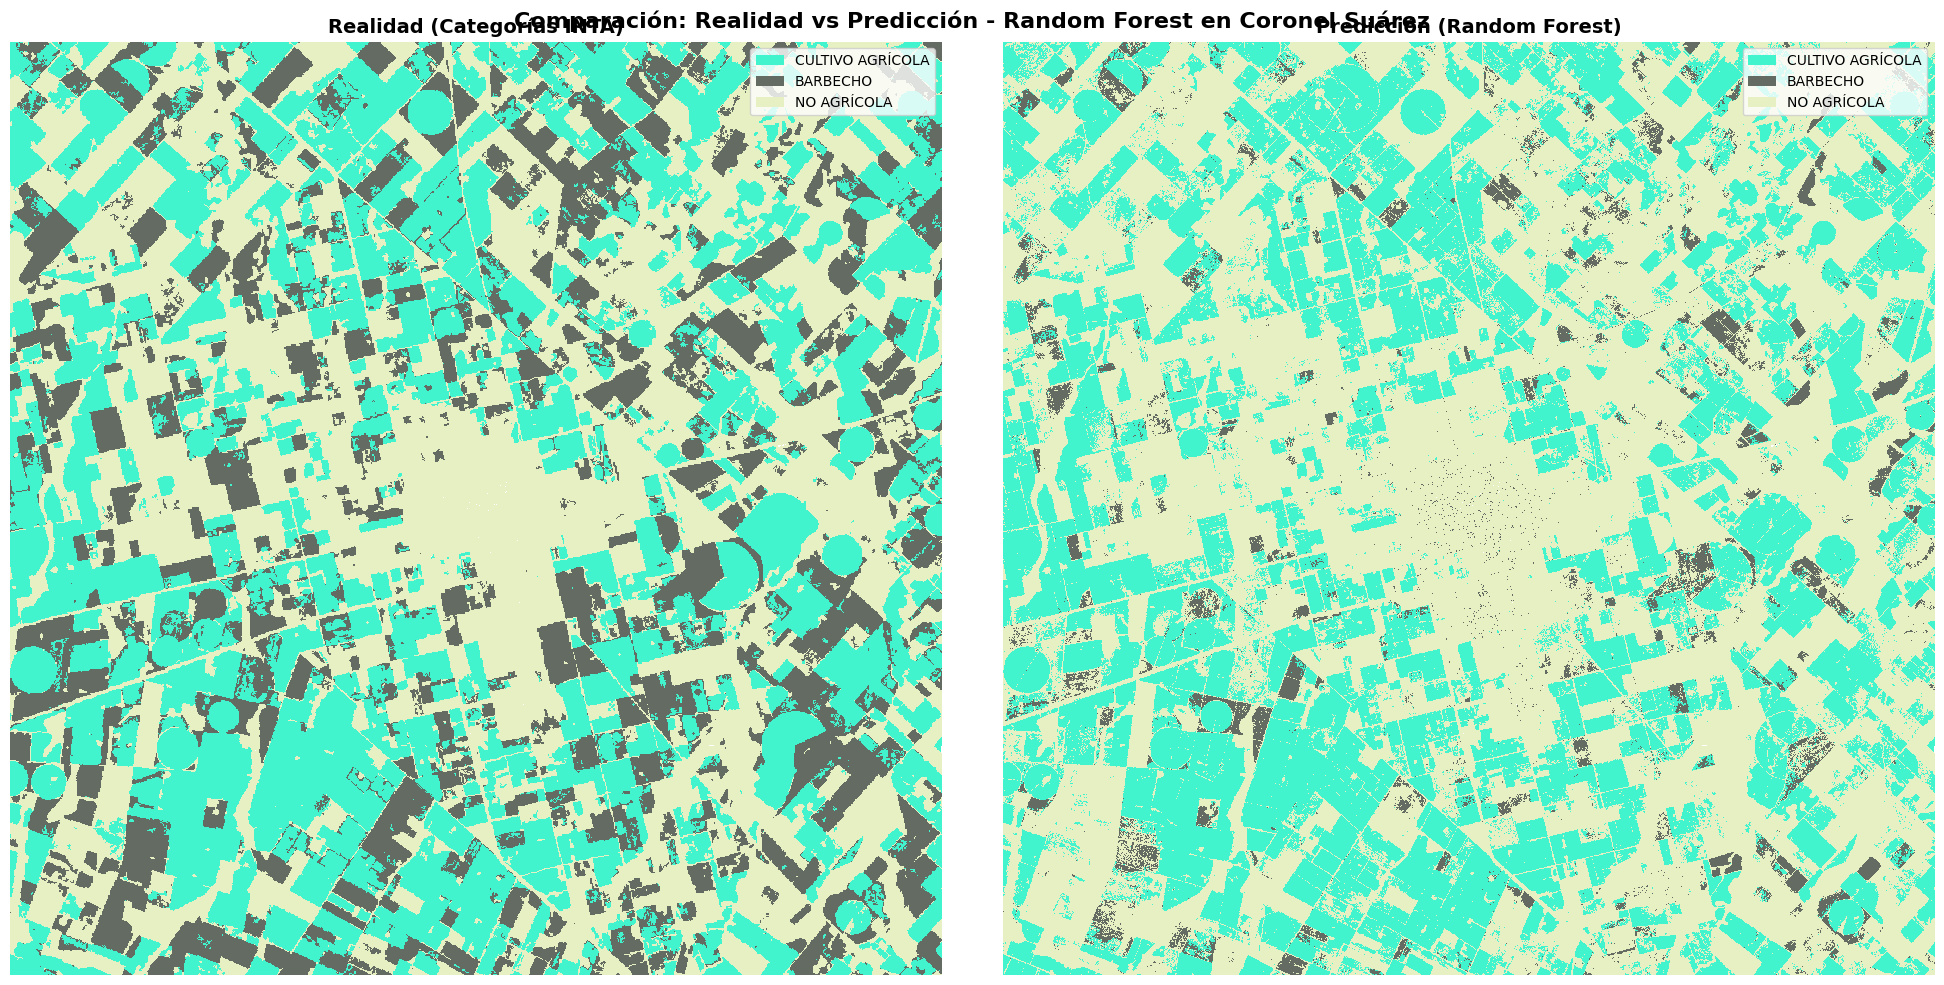


Accuracy espacial (sobre mapa completo): 0.7348 (73.48%)


In [20]:
# ============================================================================
# VISUALIZACION: REALIDAD VS PREDICCION
# ============================================================================

print("=" * 80)
print("GENERANDO MAPAS 2D")
print("=" * 80)

# Crear mapas 2D
mapa_realidad = np.full((height, width), -1, dtype=np.int32)
mapa_prediccion = np.full((height, width), -1, dtype=np.int32)

mapa_realidad.flat[indices_clean] = y_clean
mapa_prediccion.flat[indices_clean] = y_pred

print(f"[OK] Mapas 2D generados")

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Colormap personalizado con colores del QML
# Orden: CULTIVO AGRÍCOLA (0), BARBECHO (1), NO AGRÍCOLA (2), No válido (-1)
# Colores del QML: BARBECHO (#646b63), NO AGRÍCOLA (#e6f0c2)
# Para CULTIVO AGRÍCOLA usamos un color distintivo (verde azulado)
colores_custom = ['#42f4ce', '#646b63', '#e6f0c2', '#ffffff']  # Verde azulado, Gris, Beige (QML), Blanco
cmap_custom = ListedColormap(colores_custom)

# Crear BoundaryNorm para mapeo discreto de clases
# Boundaries extendidos para mapear correctamente valores 0, 1, 2 a colores 0, 1, 2
# Los valores -1 se manejarán como máscara (NaN)
# Necesitamos boundaries que incluyan el rango completo hasta 2.5 para que el valor 2 mapee al índice 2
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(boundaries, cmap_custom.N)

# Preparar mapas para visualización (convertir -1 a NaN para que se muestren en blanco)
mapa_realidad_viz = mapa_realidad.copy().astype(float)
mapa_realidad_viz[mapa_realidad_viz == -1] = np.nan

mapa_prediccion_viz = mapa_prediccion.copy().astype(float)
mapa_prediccion_viz[mapa_prediccion_viz == -1] = np.nan

# Subplot izquierdo: Realidad
ax1 = axes[0]
im1 = ax1.imshow(mapa_realidad_viz, cmap=cmap_custom, norm=norm, interpolation='nearest')
ax1.set_title('Realidad (Categorías INTA)', fontsize=14, fontweight='bold')
ax1.axis('off')

# Leyenda para realidad
handles_realidad = [
    Patch(facecolor=colores_custom[0], label='CULTIVO AGRÍCOLA'),
    Patch(facecolor=colores_custom[1], label='BARBECHO'),
    Patch(facecolor=colores_custom[2], label='NO AGRÍCOLA')
]
ax1.legend(handles=handles_realidad, loc='upper right', fontsize=10)

# Subplot derecho: Predicción
ax2 = axes[1]
im2 = ax2.imshow(mapa_prediccion_viz, cmap=cmap_custom, norm=norm, interpolation='nearest')
ax2.set_title('Predicción (Random Forest)', fontsize=14, fontweight='bold')
ax2.axis('off')

# Leyenda para predicción
handles_prediccion = [
    Patch(facecolor=colores_custom[0], label='CULTIVO AGRÍCOLA'),
    Patch(facecolor=colores_custom[1], label='BARBECHO'),
    Patch(facecolor=colores_custom[2], label='NO AGRÍCOLA')
]
ax2.legend(handles=handles_prediccion, loc='upper right', fontsize=10)

plt.suptitle('Comparación: Realidad vs Predicción - Random Forest en Coronel Suárez', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Calcular accuracy espacial (sobre mapa completo)
mask_comparacion = (mapa_realidad >= 0) & (mapa_prediccion >= 0)
aciertos = (mapa_realidad[mask_comparacion] == mapa_prediccion[mask_comparacion]).sum()
total_comparacion = mask_comparacion.sum()
accuracy_espacial = aciertos / total_comparacion if total_comparacion > 0 else 0

print(f"\nAccuracy espacial (sobre mapa completo): {accuracy_espacial:.4f} ({accuracy_espacial*100:.2f}%)")


MATRIZ DE CONFUSION NORMALIZADA


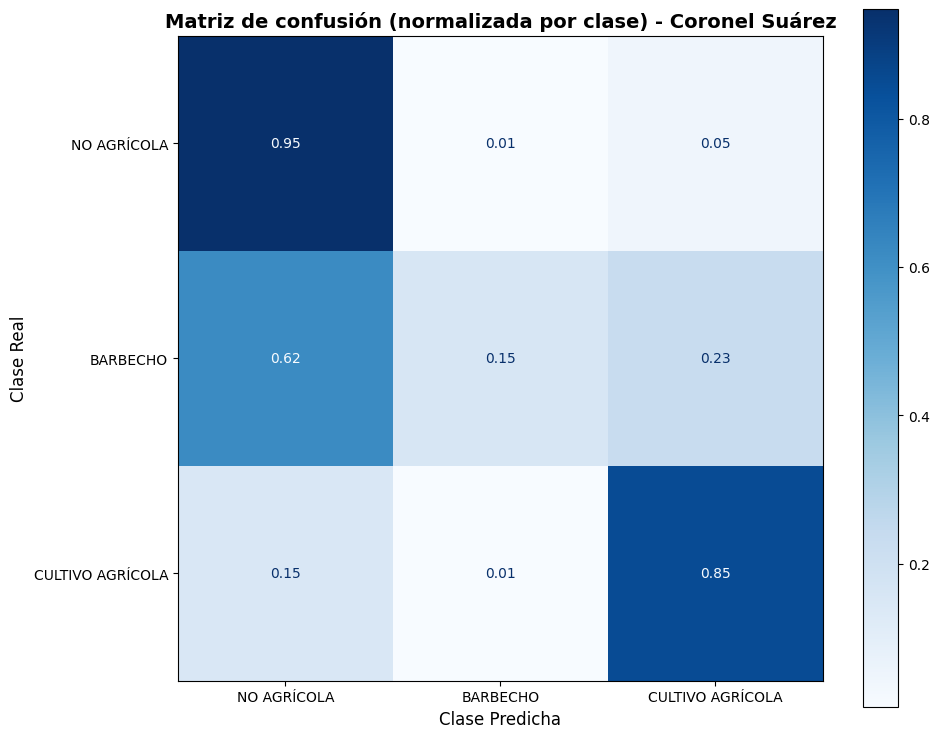


[OK] Matriz de confusión normalizada generada

Valores de la matriz (normalizada por fila):
                    NO AGRÍCOLA         BARBECHO            CULTIVO AGRÍCOLA    
NO AGRÍCOLA                         0.95                0.01                0.05
BARBECHO                            0.62                0.15                0.23
CULTIVO AGRÍCOLA                    0.15                0.01                0.85


In [21]:
# ============================================================================
# MATRIZ DE CONFUSION NORMALIZADA
# ============================================================================

print("=" * 80)
print("MATRIZ DE CONFUSION NORMALIZADA")
print("=" * 80)

# Calcular matriz de confusión
cm = confusion_matrix(y_clean, y_pred)

# Normalizar por fila (recall por clase)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Nombres de clases según el mapeo del código:
# 0 = CULTIVO AGRÍCOLA, 1 = BARBECHO, 2 = NO AGRÍCOLA
# Reordenar matriz: índices [2, 1, 0] corresponden a [NO AGRÍCOLA, BARBECHO, CULTIVO AGRÍCOLA]
indices_reordenados = [2, 1, 0]
cm_normalized_reordenada = cm_normalized[np.ix_(indices_reordenados, indices_reordenados)]
nombres_clases_orden = ["NO AGRÍCOLA", "BARBECHO", "CULTIVO AGRÍCOLA"]

# Crear visualización
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Usar ConfusionMatrixDisplay para mejor visualización
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_reordenada, display_labels=nombres_clases_orden)
disp.plot(ax=ax, values_format='.2f', cmap='Blues')

ax.set_title('Matriz de confusión (normalizada por clase) - Coronel Suárez', fontsize=14, fontweight='bold')
ax.set_xlabel('Clase Predicha', fontsize=12)
ax.set_ylabel('Clase Real', fontsize=12)

plt.tight_layout()
plt.show()

print("\n[OK] Matriz de confusión normalizada generada")
print(f"\nValores de la matriz (normalizada por fila):")
print("                    ", end="")
for nombre in nombres_clases_orden:
    print(f"{nombre:20s}", end="")
print()
for i, nombre in enumerate(nombres_clases_orden):
    print(f"{nombre:20s}", end="")
    for j in range(len(nombres_clases_orden)):
        print(f"{cm_normalized_reordenada[i, j]:20.2f}", end="")
    print()


## Mapa de errores


MAPA DE ERRORES

Estadísticas del mapa de errores:
  Aciertos: 5,153,912 (73.48%)
  Errores totales: 1,860,207 (26.52%)

  Desglose de errores:
    CULTIVO AGRÍCOLA -> BARBECHO: 16,021
    CULTIVO AGRÍCOLA -> NO AGRÍCOLA: 384,765
    BARBECHO -> CULTIVO AGRÍCOLA: 352,098
    BARBECHO -> NO AGRÍCOLA: 958,684
    NO AGRÍCOLA -> CULTIVO AGRÍCOLA: 128,873
    NO AGRÍCOLA -> BARBECHO: 19,766
  Total: 7,014,119


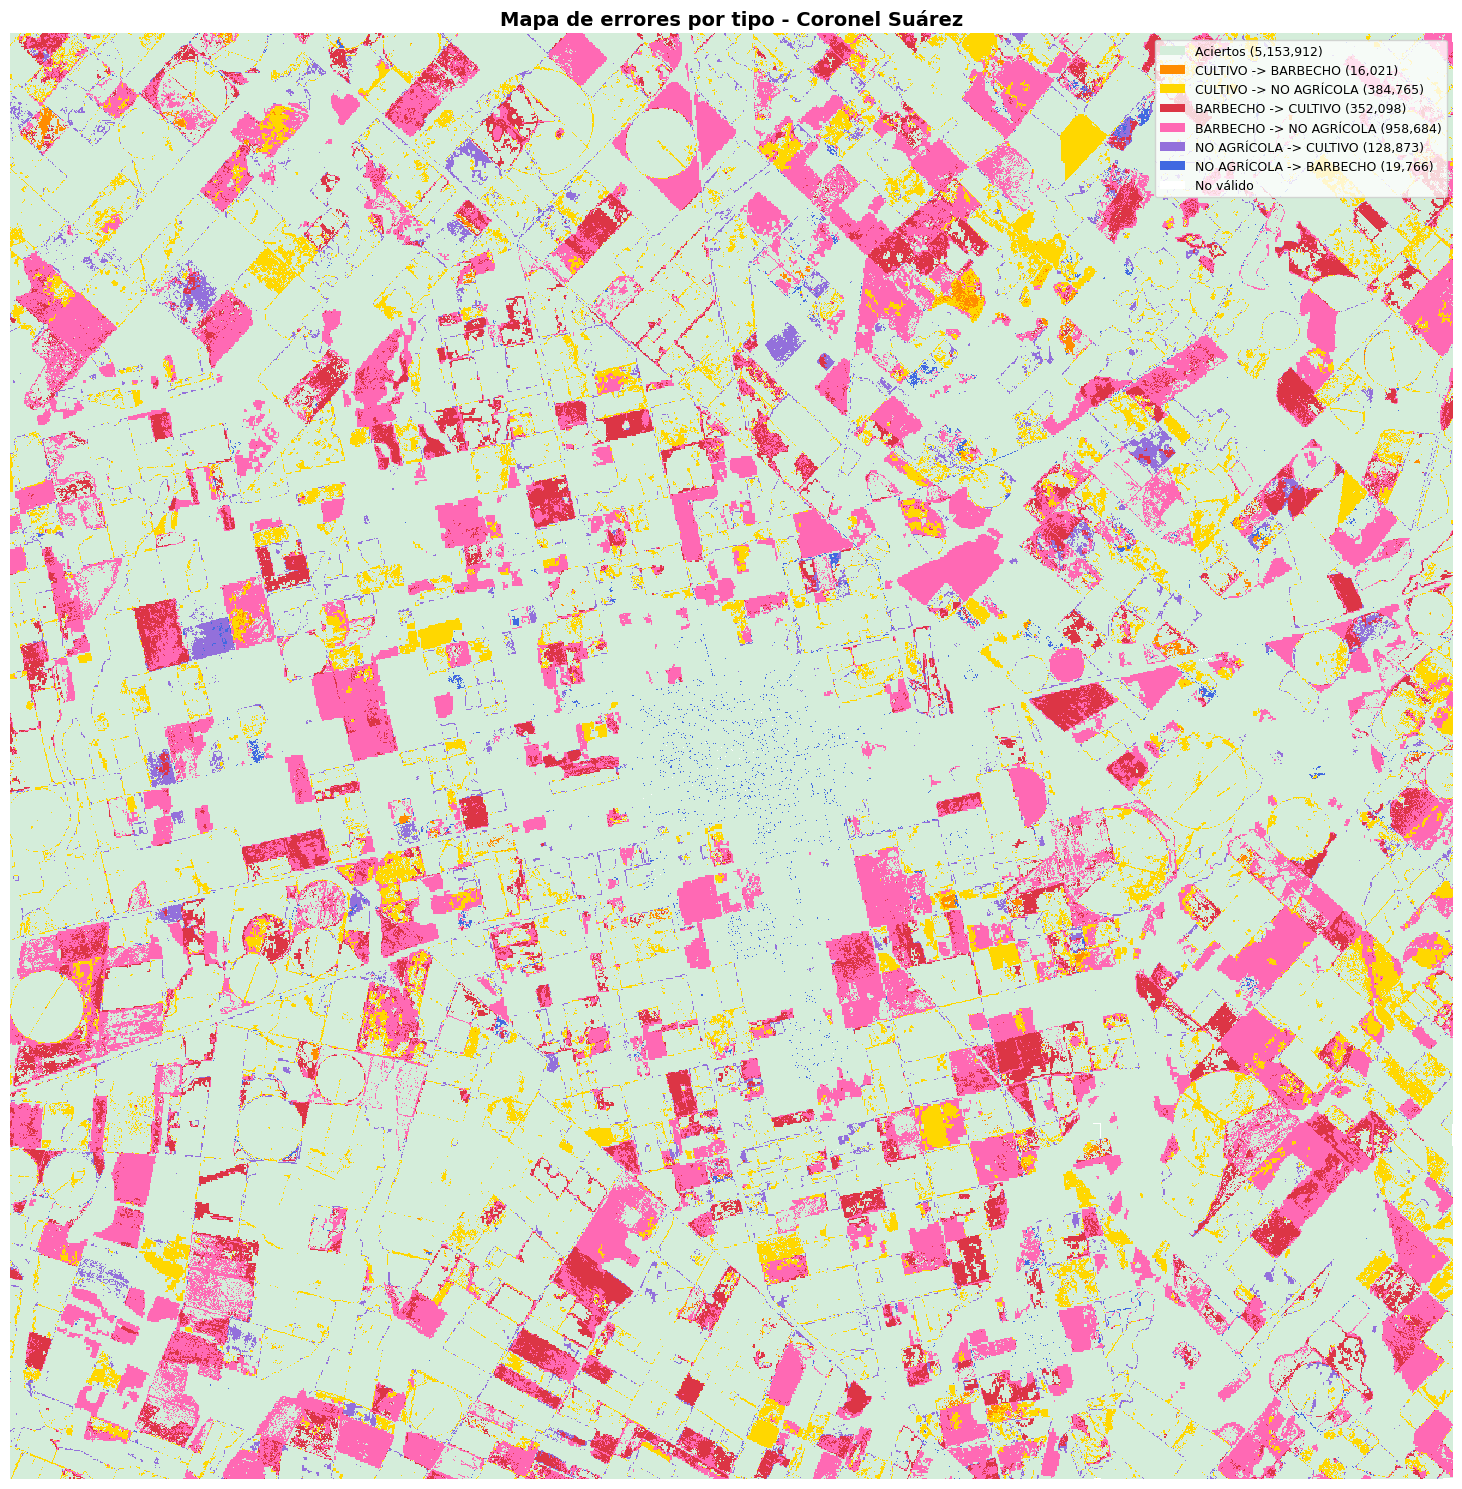


[OK] Mapa de errores generado


In [28]:
# ============================================================================
# MAPA DE ERRORES
# ============================================================================

print("=" * 80)
print("MAPA DE ERRORES")
print("=" * 80)

# Crear mapa de errores con códigos diferenciados por tipo de error
# Códigos: 
# -1 = no válido
# 0 = acierto (mapa_prediccion == mapa_realidad)
# 1 = CULTIVO AGRÍCOLA predicho como BARBECHO
# 2 = CULTIVO AGRÍCOLA predicho como NO AGRÍCOLA
# 3 = BARBECHO predicho como CULTIVO AGRÍCOLA
# 4 = BARBECHO predicho como NO AGRÍCOLA
# 5 = NO AGRÍCOLA predicho como CULTIVO AGRÍCOLA
# 6 = NO AGRÍCOLA predicho como BARBECHO
# Usar las dimensiones de mapa_realidad para asegurar compatibilidad
error_map = np.full_like(mapa_realidad, -1, dtype=np.int32)

# Solo comparar donde hay datos válidos
mask_valido_map = (mapa_realidad >= 0) & (mapa_prediccion >= 0)

# Crear máscaras para cada clase real
mask_cultivo = (mapa_realidad == 0) & mask_valido_map
mask_barbecho = (mapa_realidad == 1) & mask_valido_map
mask_no_agricola = (mapa_realidad == 2) & mask_valido_map

# Aciertos (todas las clases)
error_map[mask_valido_map & (mapa_prediccion == mapa_realidad)] = 0

# Errores: CULTIVO AGRÍCOLA mal clasificado
error_map[mask_cultivo & (mapa_prediccion == 1)] = 1  # CULTIVO -> BARBECHO
error_map[mask_cultivo & (mapa_prediccion == 2)] = 2  # CULTIVO -> NO AGRÍCOLA

# Errores: BARBECHO mal clasificado
error_map[mask_barbecho & (mapa_prediccion == 0)] = 3  # BARBECHO -> CULTIVO
error_map[mask_barbecho & (mapa_prediccion == 2)] = 4  # BARBECHO -> NO AGRÍCOLA

# Errores: NO AGRÍCOLA mal clasificado
error_map[mask_no_agricola & (mapa_prediccion == 0)] = 5  # NO AGRÍCOLA -> CULTIVO
error_map[mask_no_agricola & (mapa_prediccion == 1)] = 6  # NO AGRÍCOLA -> BARBECHO

# Calcular estadísticas
n_aciertos = (error_map[mask_valido_map] == 0).sum()
n_errores = (error_map[mask_valido_map] > 0).sum()
n_total = mask_valido_map.sum()
accuracy_map = n_aciertos / n_total if n_total > 0 else 0

# Estadísticas por tipo de error
n_error_cultivo_barbecho = (error_map == 1).sum()
n_error_cultivo_no_agricola = (error_map == 2).sum()
n_error_barbecho_cultivo = (error_map == 3).sum()
n_error_barbecho_no_agricola = (error_map == 4).sum()
n_error_no_agricola_cultivo = (error_map == 5).sum()
n_error_no_agricola_barbecho = (error_map == 6).sum()

print(f"\nEstadísticas del mapa de errores:")
print(f"  Aciertos: {n_aciertos:,} ({100*n_aciertos/n_total:.2f}%)")
print(f"  Errores totales: {n_errores:,} ({100*n_errores/n_total:.2f}%)")
print(f"\n  Desglose de errores:")
print(f"    CULTIVO AGRÍCOLA -> BARBECHO: {n_error_cultivo_barbecho:,}")
print(f"    CULTIVO AGRÍCOLA -> NO AGRÍCOLA: {n_error_cultivo_no_agricola:,}")
print(f"    BARBECHO -> CULTIVO AGRÍCOLA: {n_error_barbecho_cultivo:,}")
print(f"    BARBECHO -> NO AGRÍCOLA: {n_error_barbecho_no_agricola:,}")
print(f"    NO AGRÍCOLA -> CULTIVO AGRÍCOLA: {n_error_no_agricola_cultivo:,}")
print(f"    NO AGRÍCOLA -> BARBECHO: {n_error_no_agricola_barbecho:,}")
print(f"  Total: {n_total:,}")

# Crear visualización
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Colormap con colores distintos para cada tipo de error
# Orden: [-1, 0, 1, 2, 3, 4, 5, 6]
# -1: no válido (blanco)
# 0: acierto (verde claro)
# 1: CULTIVO -> BARBECHO (naranja)
# 2: CULTIVO -> NO AGRÍCOLA (amarillo)
# 3: BARBECHO -> CULTIVO (rojo)
# 4: BARBECHO -> NO AGRÍCOLA (rosa)
# 5: NO AGRÍCOLA -> CULTIVO (morado)
# 6: NO AGRÍCOLA -> BARBECHO (azul)
colores_errores = [
    '#ffffff',  # -1: No válido (blanco)
    '#d4edda',  # 0: Acierto (verde claro)
    '#ff8c00',  # 1: CULTIVO -> BARBECHO (naranja)
    '#ffd700',  # 2: CULTIVO -> NO AGRÍCOLA (amarillo)
    '#dc3545',  # 3: BARBECHO -> CULTIVO (rojo)
    '#ff69b4',  # 4: BARBECHO -> NO AGRÍCOLA (rosa)
    '#9370db',  # 5: NO AGRÍCOLA -> CULTIVO (morado)
    '#4169e1'   # 6: NO AGRÍCOLA -> BARBECHO (azul)
]
cmap_errores = ListedColormap(colores_errores)

# Usar BoundaryNorm para mapear correctamente los valores
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm = BoundaryNorm(bounds, cmap_errores.N)

im = ax.imshow(error_map, cmap=cmap_errores, norm=norm, interpolation='nearest')
ax.set_title('Mapa de errores por tipo - Coronel Suárez', fontsize=14, fontweight='bold')
ax.axis('off')

# Agregar leyenda con todos los tipos
handles_errores = [
    Patch(facecolor=colores_errores[1], label=f'Aciertos ({n_aciertos:,})'),
    Patch(facecolor=colores_errores[2], label=f'CULTIVO -> BARBECHO ({n_error_cultivo_barbecho:,})'),
    Patch(facecolor=colores_errores[3], label=f'CULTIVO -> NO AGRÍCOLA ({n_error_cultivo_no_agricola:,})'),
    Patch(facecolor=colores_errores[4], label=f'BARBECHO -> CULTIVO ({n_error_barbecho_cultivo:,})'),
    Patch(facecolor=colores_errores[5], label=f'BARBECHO -> NO AGRÍCOLA ({n_error_barbecho_no_agricola:,})'),
    Patch(facecolor=colores_errores[6], label=f'NO AGRÍCOLA -> CULTIVO ({n_error_no_agricola_cultivo:,})'),
    Patch(facecolor=colores_errores[7], label=f'NO AGRÍCOLA -> BARBECHO ({n_error_no_agricola_barbecho:,})'),
    Patch(facecolor=colores_errores[0], label='No válido')
]
ax.legend(handles=handles_errores, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print("\n[OK] Mapa de errores generado")


## Comparación de áreas por clase: Real vs Predicho


COMPARACION DE AREAS POR CLASE

Comparación de áreas por clase:
           clase  area_real  area_predicha
     NO AGRÍCOLA    2842386        4037196
        BARBECHO    1549264         274269
CULTIVO AGRÍCOLA    2622469        2702654


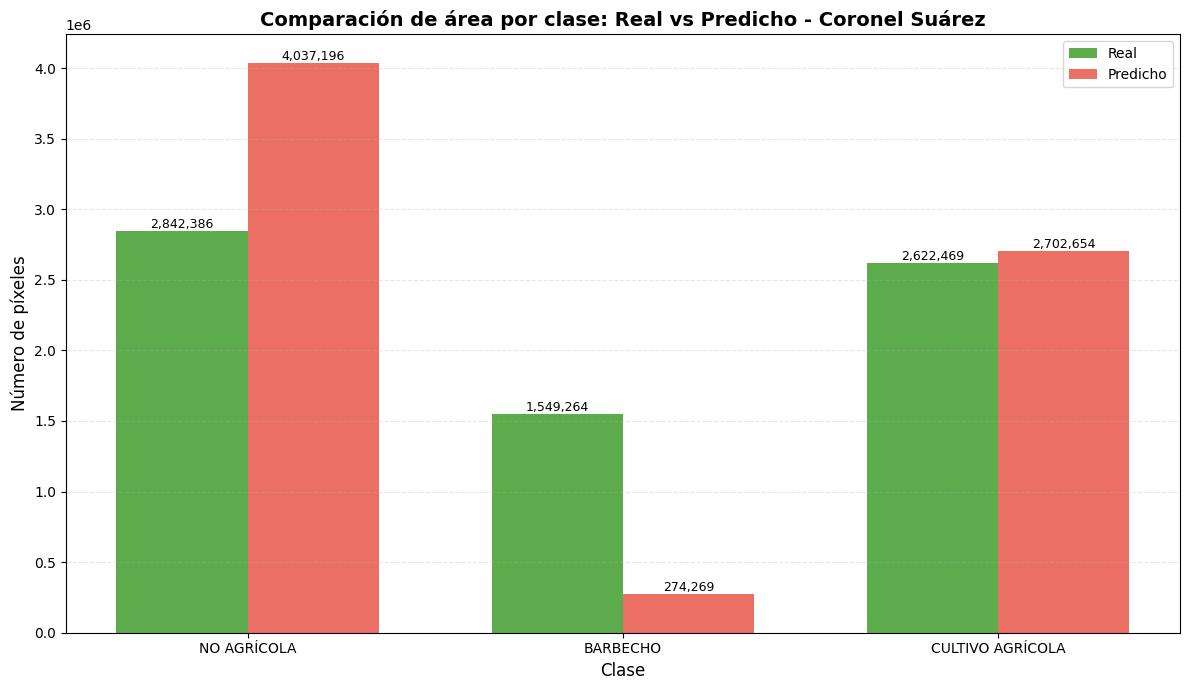


[OK] Comparación de áreas por clase generada


In [23]:
# ============================================================================
# COMPARACION DE AREAS POR CLASE: REAL VS PREDICHO
# ============================================================================

print("=" * 80)
print("COMPARACION DE AREAS POR CLASE")
print("=" * 80)

# Calcular conteos por clase
clases_reales, conteos_reales = np.unique(y_clean, return_counts=True)
clases_predichas, conteos_predichas = np.unique(y_pred, return_counts=True)

# Crear diccionarios para facilitar el acceso
dict_real = dict(zip(clases_reales, conteos_reales))
dict_pred = dict(zip(clases_predichas, conteos_predichas))

# Mapeo del código: 0=CULTIVO AGRÍCOLA, 1=BARBECHO, 2=NO AGRÍCOLA
# Orden de visualización deseado: NO AGRÍCOLA, BARBECHO, CULTIVO AGRÍCOLA
nombres_clases_orden = ["NO AGRÍCOLA", "BARBECHO", "CULTIVO AGRÍCOLA"]
clases_orden = [2, 1, 0]  # Mapeo: clase 2 (NO AGRÍCOLA), clase 1 (BARBECHO), clase 0 (CULTIVO AGRÍCOLA)

# Construir DataFrame
data_comparacion = []
for nombre, clase_idx in zip(nombres_clases_orden, clases_orden):
    area_real = dict_real.get(clase_idx, 0)
    area_predicha = dict_pred.get(clase_idx, 0)
    data_comparacion.append({
        'clase': nombre,
        'area_real': area_real,
        'area_predicha': area_predicha
    })

df_comparacion = pd.DataFrame(data_comparacion)

print("\nComparación de áreas por clase:")
print(df_comparacion.to_string(index=False))

# Crear gráfico de barras agrupadas
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

x = np.arange(len(nombres_clases_orden))
width = 0.35

bars1 = ax.bar(x - width/2, df_comparacion['area_real'], width, label='Real', color='#339820', alpha=0.8)
bars2 = ax.bar(x + width/2, df_comparacion['area_predicha'], width, label='Predicho', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Clase', fontsize=12)
ax.set_ylabel('Número de píxeles', fontsize=12)
ax.set_title('Comparación de área por clase: Real vs Predicho - Coronel Suárez', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(nombres_clases_orden)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.3, axis='y')

# Agregar valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n[OK] Comparación de áreas por clase generada")
